# Imports

In [47]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import r2_score
plt.style.use('dark_background')

# Loading the Dataframe

In [2]:
pwd

'/home/rafael/code/rafabertolace/OnThePitch/notebooks'

## Merging the Seasons csv files (2019-2020 untill 2021-2022)

In [3]:
print(os.listdir('../raw_data/Turkey'))

['Turkey_2020-2021.csv', 'Turkey_2019-2020.csv', 'Turkey_2021-2022.csv']


In [4]:
files = [file for file in os.listdir('../raw_data/Turkey') if file.endswith('.csv')]
data = pd.DataFrame()

for file in files:
    df = pd.read_csv('../raw_data/Turkey/' + file)
    data = pd.concat([data, df])

In [5]:
data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,T1,11/09/2020,18:00,Rizespor,Fenerbahce,1,2,A,0,0,...,2.11,0.50,1.95,1.90,1.94,1.94,1.99,1.99,1.93,1.90
1,T1,12/09/2020,15:00,Karagumruk,Yeni Malatyaspor,3,0,H,1,0,...,1.93,0.00,2.02,1.83,2.01,1.89,2.08,1.90,2.01,1.84
2,T1,12/09/2020,15:00,Sivasspor,Alanyaspor,0,2,A,0,1,...,2.13,-0.25,1.85,2.00,1.85,2.06,1.93,2.06,1.84,2.01
3,T1,12/09/2020,18:00,Galatasaray,Gaziantep,3,1,H,3,0,...,2.32,-1.00,1.88,1.98,1.94,1.96,1.97,2.04,1.87,1.97
4,T1,12/09/2020,18:00,Goztep,Denizlispor,5,1,H,3,0,...,1.77,-0.25,1.93,1.93,1.94,1.96,1.97,1.98,1.91,1.93


In [6]:
for col_name in data.columns: 
    print(col_name)

Div
Date
Time
HomeTeam
AwayTeam
FTHG
FTAG
FTR
HTHG
HTAG
HTR
HS
AS
HST
AST
HF
AF
HC
AC
HY
AY
HR
AR
B365H
B365D
B365A
BWH
BWD
BWA
IWH
IWD
IWA
PSH
PSD
PSA
WHH
WHD
WHA
VCH
VCD
VCA
MaxH
MaxD
MaxA
AvgH
AvgD
AvgA
B365>2.5
B365<2.5
P>2.5
P<2.5
Max>2.5
Max<2.5
Avg>2.5
Avg<2.5
AHh
B365AHH
B365AHA
PAHH
PAHA
MaxAHH
MaxAHA
AvgAHH
AvgAHA
B365CH
B365CD
B365CA
BWCH
BWCD
BWCA
IWCH
IWCD
IWCA
PSCH
PSCD
PSCA
WHCH
WHCD
WHCA
VCCH
VCCD
VCCA
MaxCH
MaxCD
MaxCA
AvgCH
AvgCD
AvgCA
B365C>2.5
B365C<2.5
PC>2.5
PC<2.5
MaxC>2.5
MaxC<2.5
AvgC>2.5
AvgC<2.5
AHCh
B365CAHH
B365CAHA
PCAHH
PCAHA
MaxCAHH
MaxCAHA
AvgCAHH
AvgCAHA


# Over/Under DF

In [7]:
data.isnull().sum().sort_values(ascending=False)

VCA        9
VCH        9
VCD        9
B365AHA    8
B365AHH    8
          ..
MaxA       0
MaxD       0
MaxH       0
AR         0
AvgCAHA    0
Length: 105, dtype: int64

In [8]:
data.dropna(inplace=True)

In [9]:
data

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,T1,11/09/2020,18:00,Rizespor,Fenerbahce,1,2,A,0,0,...,2.11,0.50,1.95,1.90,1.94,1.94,1.99,1.99,1.93,1.90
1,T1,12/09/2020,15:00,Karagumruk,Yeni Malatyaspor,3,0,H,1,0,...,1.93,0.00,2.02,1.83,2.01,1.89,2.08,1.90,2.01,1.84
2,T1,12/09/2020,15:00,Sivasspor,Alanyaspor,0,2,A,0,1,...,2.13,-0.25,1.85,2.00,1.85,2.06,1.93,2.06,1.84,2.01
3,T1,12/09/2020,18:00,Galatasaray,Gaziantep,3,1,H,3,0,...,2.32,-1.00,1.88,1.98,1.94,1.96,1.97,2.04,1.87,1.97
4,T1,12/09/2020,18:00,Goztep,Denizlispor,5,1,H,3,0,...,1.77,-0.25,1.93,1.93,1.94,1.96,1.97,1.98,1.91,1.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,T1,21/05/2022,17:00,Yeni Malatyaspor,Fenerbahce,0,5,A,0,1,...,2.91,1.75,1.88,1.98,1.93,1.96,2.09,2.01,1.97,1.89
376,T1,22/05/2022,14:00,Buyuksehyr,Trabzonspor,3,1,H,3,0,...,2.12,-1.25,2.02,1.77,2.09,1.83,2.17,1.85,2.10,1.77
377,T1,22/05/2022,14:00,Karagumruk,Alanyaspor,0,1,A,0,1,...,2.46,0.25,1.88,1.98,1.88,2.02,1.94,2.02,1.90,1.95
378,T1,22/05/2022,17:00,Ad. Demirspor,Goztep,7,0,H,5,0,...,2.98,-1.25,1.95,1.90,1.97,1.93,2.05,2.08,1.98,1.87


# Features Engineering

### Number of Goals, Over and Under

In [10]:
# total number of goals = goals from the home team + goals from visiting team
data['nb_goals']=data['FTHG']+data['FTAG']

# boolean: true or false regarding whether they were more than 2.5 goals
data['over_2.5_goals']=data['nb_goals']>2.5

# boolean: true or false regarding whether they were less than 2.5 goals
data['under_2.5_goals']=data['nb_goals']<2.5

### Payout

  Payout of betting on over/under 2.5 goals: we get 0 if we lose the bet, we get the Avg if we win the bet (Avg = market average of the odds)


#### Payout Opening

In [11]:
# payout under 2.5 for Average OPENING odds
data['Payout Under AVG'] = data['under_2.5_goals']*data['Avg<2.5']

# payout over 2.5 for Average OPENING odds
data['Payout Over AVG'] = data['over_2.5_goals']*data['Avg>2.5']

#payout UNDER 2.5 for PINACLE specifically
data['Payout Under P'] = data['under_2.5_goals']*data['P<2.5']

#payout OVER 2.5 for PINACLE specifically
data['Payout Over P'] = data['over_2.5_goals']*data['P>2.5']

#payout UNDER 2.5 for 365 specifically
data['Payout Under B365'] = data['under_2.5_goals']*data['B365<2.5']

#payout OVER 2.5 for 365 specifically
data['Payout Over B365'] = data['over_2.5_goals']*data['B365>2.5']

#### Payout Closing

In [12]:
# payout under 2.5 for Average CLOSING odds
data['Payout Under AVGC'] = data['under_2.5_goals']*data['AvgC<2.5']

# payout over 2.5 for Average CLOSING odds
data['Payout Over AVG'] = data['over_2.5_goals']*data['AvgC>2.5']

#payout UNDER 2.5 for PINACLE closing ddds specifically
data['Payout Under PC'] = data['under_2.5_goals']*data['PC<2.5']

#payout OVER 2.5 for PINACLE closing odds specifically
data['Payout Over PC'] = data['over_2.5_goals']*data['PC>2.5']

#payout UNDER 2.5 for 365 closing odds specifically
data['Payout Under B365C'] = data['under_2.5_goals']*data['B365C<2.5']

#payout OVER 2.5 for 365 closing odds specifically
data['Payout Over B365C'] = data['over_2.5_goals']*data['B365C>2.5']

### Implied Probability

#### Implied Probability Opening

In [13]:
#Implied Probability UNDER 2.5 goals for for overall market opening odds (Avg) 
data['IP Under 2.5 AVG']=1/data['Avg<2.5']*100

#Implied Probability OVER 2.5 goals for for overall market opening odds (Avg) 
data['IP Over 2.5 AVG']=1/data['Avg>2.5']*100

#Implied Probability UNDER 2.5 goals for PINACLE
data['IP Under 2.5 P']=1/data['P<2.5']*100

#Implied Probability OVER 2.5 goals for PINACLE
data['IP Over 2.5 P']=1/data['P>2.5']*100

#Implied Probability UNDER 2.5 goals for 365
data['IP Under 2.5 B365']=1/data['B365<2.5']*100

#Implied Probability OVER 2.5 goals for 365
data['IP Over 2.5 B365']=1/data['B365>2.5']*100

#### Implied Probability Closing

In [14]:
#Implied Probability UNDER 2.5 goals for overall market closing odds (AvgC)
data['IP Under 2.5 AVGC']=1/data['AvgC<2.5']*100

#Implied Probability OVER 2.5 goals for overall market closing odds (AvgC)
data['IP Over 2.5 AVGC']=1/data['AvgC>2.5']*100
 
#Implied Probability UNDER 2.5 goals for PINACLE closing odds
data['IP Under 2.5 PC']=1/data['PC<2.5']*100

#Implied Probability OVER 2.5 goals for PINACLE closing odds
data['IP Over 2.5 PC']=1/data['PC>2.5']*100

#Implied Probability UNDER 2.5 goals for 365 closing odds
data['IP Under 2.5 B365C']=1/data['B365C<2.5']*100

#Implied Probability OVER 2.5 goals for 365 closing odds
data['IP Under 2.5 B365C']=1/data['B365C>2.5']*100

### Binning the implied probabilities

#### Binning IP Opening

In [15]:
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

#Binning UNDER 2.5 Average Market opening odds
data['Bin IP Under AVG'] = pd.cut(data['IP Under 2.5 AVG'], bins)

#Binning Over 2.5 Average Market opening odds
data['Bin IP Over AVG'] = pd.cut(data['IP Over 2.5 AVG'], bins)

#Binned UNDER 2.5 Pinnacle opening odds
data['Bin IP Under P'] = pd.cut(data['IP Under 2.5 P'], bins)

#Binned OVER 2.5 Pinnacle
data['Bin IP Over P'] = pd.cut(data['IP Over 2.5 P'], bins)

#Binned UNDER 2.5 bet365 OPENING odds
data['Bin IP Under B365'] = pd.cut(data['IP Under 2.5 B365'], bins)

#Binned OVER 2.5 bet365 OPENING odds
data['Bin IP Over B365'] = pd.cut(data['IP Over 2.5 B365'], bins)

#### Binning IP Closing

In [16]:
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

#Binning UNDER 2.5 Average Market closing odds
data['Bin IP Under AVGC'] = pd.cut(data['IP Under 2.5 AVGC'], bins)

#Binning OVER 2.5 Average Market closing odds
data['Bin IP Over AVGC'] = pd.cut(data['IP Over 2.5 AVGC'], bins)

#Binned UNDER 2.5 Pinnacle closing odds
data['Bin IP Under PC'] = pd.cut(data['IP Under 2.5 PC'], bins)

#Binned OVER 2.5 Pinnacle CLOSING odds
data['Bin IP Over PC'] = pd.cut(data['IP Over 2.5 PC'], bins)

#Binned UNDER 2.5 bet365 CLOSING odds
data['Bin IP Under B365C'] = pd.cut(data['IP Over 2.5 B365C'], bins)

#Binned OVER 2.5 bet365 CLOSING odds
data['Bin IP Over B365C'] = pd.cut(data['IP Over 2.5 B365C'], bins)

### Binning the odds

#### Binning Odds Opening

In [17]:
bins = [1, 1.5, 2, 3, 99999]

#Binning UNDER 2.5 Average Market opening odds
data['Bin Odds Under AVG'] = pd.cut(data['Avg<2.5'], bins)

#Binning Over 2.5 Average Market opening odds
data['Bin Odds Over AVG'] = pd.cut(data['Avg>2.5'], bins)

#Binned UNDER 2.5 Pinnacle opening odds
data['Bin Odds Under P'] = pd.cut(data['P<2.5'], bins)

#Binned OVER 2.5 Pinnacle
data['Bin Odds Over P'] = pd.cut(data['P>2.5'], bins)

#Binned UNDER 2.5 bet365 OPENING odds
data['Bin Odds Under B365'] = pd.cut(data['B365<2.5'], bins)

#Binned OVER 2.5 bet365 OPENING odds
data['Bin Odds Over B365'] = pd.cut(data['B365>2.5'], bins)

#### Binning Odds Closing

In [18]:
bins = [1, 1.25, 2, 3, 99999]

#Binning UNDER 2.5 Average Market opening odds
data['Bin Odds Under AVGC'] = pd.cut(data['AvgC<2.5'], bins)

#Binning Over 2.5 Average Market opening odds
data['Bin Odds Over AVGC'] = pd.cut(data['AvgC>2.5'], bins)

#Binned UNDER 2.5 Pinnacle opening odds
data['Bin Odds Under PC'] = pd.cut(data['PC<2.5'], bins)

#Binned OVER 2.5 Pinnacle
data['Bin Odds Over PC'] = pd.cut(data['PC>2.5'], bins)

#Binned UNDER 2.5 bet365 OPENING odds
data['Bin Odds Under B365C'] = pd.cut(data['B365C<2.5'], bins)

#Binned OVER 2.5 bet365 OPENING odds
data['Bin Odds Over B365C'] = pd.cut(data['B365C>2.5'], bins)

### Other Features from D3

In [19]:
data['PC Pays Better AVGC Bool'] = data['PC<2.5'] > data['AvgC<2.5']

In [20]:
data['PC Pays Better AVGC Diff'] = data['PC<2.5'] / data['AvgC<2.5']

In [21]:
data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100

In [22]:
data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100

In [23]:
data['PC Under Odds Less P Bool'] = data['PC<2.5'] < data['P<2.5']

In [24]:
data['PC Under Odds Less P Diff'] = data['PC<2.5'] / data['P<2.5']

# [KILL] Final Dataset [KILL]

### Opening Markets

In [25]:
#Average Market UNDER opening odds
fdf_under_avg = data[['IP Under AVG','under_2.5_goals','Bin Under AVG','Payout Under AVG']]

#Average Market OVER opening odds
fdf_over_avg = data[['IP Over AVG','over_2.5_goals','Bin Over AVG','Payout Over AVG']]

#pinnacle UNDER opening odds
fdf_under_pinacle = data[['IP Under P','under_2.5_goals','Bin Under P','Payout Under P']]

#pinnacle OVER opening odds
fdf_over_pinacle = data[['IP Over P','over_2.5_goals','Bin Over P','Payout Over P']]

#bet365 UNDER opening odds
fdf_under_365 = data[['IP Under B365','under_2.5_goals','Bin Under B365','Payout Under B365']]

#bet365 OVER opening odds
fdf_over_365 = data[['IP Over B365','over_2.5_goals','Bin Over B365','Payout Over B365']]

### Closing Markets

In [154]:
#Average Market UNDER opening odds
fdf_under_avg_closing = data[['IP Under AVGC','under_2.5_goals','Bin Under AVGC','Payout Under AVGC']]

#Average Market OVER opening odds
fdf_over_avg_closing = data[['IP Over AVGC','over_2.5_goals','Bin Over AVGC','Payout Over AVGC']]

#pinnacle UNDER opening odds
fdf_under_pinacle_closing = data[['IP Under PC','under_2.5_goals','Bin Under PC','Payout Under PC']]

#pinnacle OVER opening odds
fdf_over_pinacle_closing = data[['IP Over PC','over_2.5_goals','Bin Over PC','Payout Over PC']]

#bet365 UNDER opening odds
fdf_under_365_closing = data[['IP Under B365C','under_2.5_goals','Bin Under B365C','Payout Under B365C']]

#bet365 OVER opening odds
fdf_over_365_closing = data[['IP Over B365C','over_2.5_goals','Bin Over B365C','Payout Over B365C']]

KeyError: "['IP Under AVGC', 'Bin Under AVGC', 'Payout Under AVGC'] not in index"

# [KILL] Results per implied prob Average Market [KILL]

### Under

#### Opening Odds

In [27]:
fdf_under_avg_agg = fdf_under_avg.groupby('binned <2.5 avg')['payout_avg_under_2.5'].agg(['count', 'mean', 'median'])

fdf_under_pinacle_agg = fdf_under_pinacle.groupby('binned <2.5 pinacle')['payout_under_2.5_pinacle'].agg(['count', 'mean', 'median'])

fdf_under_bet365_agg = fdf_under_365.groupby('binned <2.5 365')['payout_under_2.5_365'].agg(['count', 'mean', 'median'])

In [28]:
fdf_under_avg_agg.rename(columns={"count": "count_avg", "mean": "mean_avg", "median": "median_avg"}, inplace=True)
fdf_under_avg_agg.index.names = ['bin<2.5']

fdf_under_pinacle_agg.rename(columns={"count": "count_p", "mean": "mean_p", "median": "median_p"}, inplace=True)
fdf_under_pinacle_agg.index.names = ['bin<2.5']

fdf_under_bet365_agg.rename(columns={"count": "count_b365", "mean": "mean_b365", "median": "median_b365"}, inplace=True)
fdf_under_bet365_agg.index.names = ['bin<2.5']

opening_test_1 = fdf_under_avg_agg.merge(fdf_under_pinacle_agg, on='bin<2.5')
opening_test_2 = opening_test_1.merge(fdf_under_bet365_agg, on='bin<2.5')
opening_test_2

,count_avg,mean_avg,median_avg,count_p,mean_p,median_p,count_b365,mean_b365,median_b365
bin<2.5,,,,,,,,,
"(0, 5]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(5, 10]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(10, 15]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(15, 20]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(20, 25]",1,0.000000,0.00,1,0.000000,0.000,1,0.000000,0.00
"(25, 30]",1,0.000000,0.00,3,0.000000,0.000,5,0.000000,0.00
"(30, 35]",10,0.295000,0.00,12,0.260000,0.000,9,0.344444,0.00
"(35, 40]",34,0.828529,0.00,47,0.997660,0.000,24,0.854167,0.00
"(40, 45]",152,0.760987,0.00,186,0.837742,0.000,134,0.728358,0.00


#### Closing Odds

In [29]:
fdf_under_avg_closing_gb_agg = fdf_under_avg_closing.groupby('binned <2.5 avg closing')['payout_avg_under_closing_2.5'].agg(['count', 'mean', 'median', mode])

fdf_under_pinacle_closing_gb_agg = fdf_under_pinacle_closing.groupby('binned <2.5 pinacle closing')['payout_under_2.5_pinacle_closing'].agg(['count', 'mean', 'median', mode])

fdf_under_bet365_closing_gb_agg = fdf_under_365_closing.groupby('binned <2.5 365 closing')['payout_under_2.5_365_closing'].agg(['count', 'mean', 'median', mode])

In [30]:
fdf_under_avg_closing_gb_agg.rename(columns={"count": "count_avg", "mean": "mean_avg", "median": "median_avg", "mode": "mode_avg"}, inplace=True)
fdf_under_avg_closing_gb_agg.index.names = ['bin<2.5']

fdf_under_pinacle_closing_gb_agg.rename(columns={"count": "count_p", "mean": "mean_p", "median": "median_p", "mode": "mode_p"}, inplace=True)
fdf_under_pinacle_closing_gb_agg.index.names = ['bin<2.5']

fdf_under_bet365_closing_gb_agg.rename(columns={"count": "count_b365", "mean": "mean_b365", "median": "median_b365", "mode": "mode_b365"}, inplace=True)
fdf_under_bet365_closing_gb_agg.index.names = ['bin<2.5']

closing_test_1 = fdf_under_avg_closing_gb_agg.merge(fdf_under_pinacle_closing_gb_agg, on='bin<2.5')
closing_test_2 = closing_test_1.merge(fdf_under_bet365_closing_gb_agg, on='bin<2.5')
closing_test_2['bins'] = closing_test_2.index
closing_test_2

,count_avg,mean_avg,median_avg,mode_avg,count_p,mean_p,median_p,mode_p,count_b365,mean_b365,median_b365,mode_b365,bins
bin<2.5,,,,,,,,,,,,,
"(0, 5]",0,NaN,NaN,"([], [])",0,NaN,NaN,"([], [])",0,NaN,NaN,"([], [])","(0, 5]"
"(5, 10]",0,NaN,NaN,"([], [])",0,NaN,NaN,"([], [])",0,NaN,NaN,"([], [])","(5, 10]"
"(10, 15]",0,NaN,NaN,"([], [])",0,NaN,NaN,"([], [])",0,NaN,NaN,"([], [])","(10, 15]"
"(15, 20]",0,NaN,NaN,"([], [])",0,NaN,NaN,"([], [])",0,NaN,NaN,"([], [])","(15, 20]"
"(20, 25]",1,0.000000,0.00,"([0.0], [1])",2,0.000000,0.00,"([0.0], [2])",2,0.000000,0.00,"([0.0], [2])","(20, 25]"
"(25, 30]",2,0.000000,0.00,"([0.0], [2])",6,0.566667,0.00,"([0.0], [5])",7,0.500000,0.00,"([0.0], [6])","(25, 30]"
"(30, 35]",14,0.233571,0.00,"([0.0], [13])",16,1.102500,0.00,"([0.0], [10])",15,0.956667,0.00,"([0.0], [10])","(30, 35]"
"(35, 40]",53,1.002642,0.00,"([0.0], [33])",76,0.559474,0.00,"([0.0], [60])",46,0.734783,0.00,"([0.0], [33])","(35, 40]"
"(40, 45]",162,0.741852,0.00,"([0.0], [110])",180,0.964500,0.00,"([0.0], [106])",143,0.779371,0.00,"([0.0], [95])","(40, 45]"


### Over

#### Opening Odds

In [31]:
fdf_over_avg_agg = fdf_over_avg.groupby('binned >2.5 avg')['payout_avg_over_2.5'].agg(['count', 'mean', 'median'])

fdf_over_pinacle_agg = fdf_over_pinacle.groupby('binned >2.5 pinacle')['payout_over_2.5_pinacle'].agg(['count', 'mean', 'median'])

fdf_over_bet365_agg = fdf_over_365.groupby('binned >2.5 365')['payout_over_2.5_365'].agg(['count', 'mean', 'median'])

In [32]:
fdf_over_avg_agg.rename(columns={"count": "count_avg", "mean": "mean_avg", "median": "median_avg"}, inplace=True)
fdf_over_avg_agg.index.names = ['bin>2.5']

fdf_over_pinacle_agg.rename(columns={"count": "count_p", "mean": "mean_p", "median": "median_p"}, inplace=True)
fdf_over_pinacle_agg.index.names = ['bin>2.5']

fdf_over_bet365_agg.rename(columns={"count": "count_b365", "mean": "mean_b365", "median": "median_b365"}, inplace=True)
fdf_over_bet365_agg.index.names = ['bin>2.5']

over_opening_test_1 = fdf_over_avg_agg.merge(fdf_over_pinacle_agg, on='bin>2.5')
over_opening_test_2 = over_opening_test_1.merge(fdf_over_bet365_agg, on='bin>2.5')
over_opening_test_2

,count_avg,mean_avg,median_avg,count_p,mean_p,median_p,count_b365,mean_b365,median_b365
bin>2.5,,,,,,,,,
"(0, 5]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(5, 10]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(10, 15]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(15, 20]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(20, 25]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(25, 30]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(30, 35]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(35, 40]",2,1.310000,1.310,2,1.390000,1.39,2,1.300000,1.30
"(40, 45]",23,1.104348,0.000,46,0.912391,0.00,23,1.097826,0.00


#### Closing Odds

In [33]:
fdf_over_avg_closing_agg = fdf_over_avg_closing.groupby('binned >2.5 avg closing')['payout_avg_over_closing_2.5'].agg(['count', 'mean', 'median'])

fdf_over_pinacle_closing_agg = fdf_over_pinacle_closing.groupby('binned >2.5 pinacle closing')['payout_over_2.5_pinacle_closing'].agg(['count', 'mean', 'median'])

fdf_over_bet365_closing_agg = fdf_over_365_closing.groupby('binned >2.5 365 closing')['payout_over_2.5_365_closing'].agg(['count', 'mean', 'median'])

In [34]:
fdf_over_avg_closing_agg.rename(columns={"count": "count_avg", "mean": "mean_avg", "median": "median_avg"}, inplace=True)
fdf_over_avg_closing_agg.index.names = ['bin>2.5']

fdf_over_pinacle_closing_agg.rename(columns={"count": "count_p", "mean": "mean_p", "median": "median_p"}, inplace=True)
fdf_over_pinacle_closing_agg.index.names = ['bin>2.5']

fdf_over_bet365_closing_agg.rename(columns={"count": "count_b365", "mean": "mean_b365", "median": "median_b365"}, inplace=True)
fdf_over_bet365_closing_agg.index.names = ['bin>2.5']

over_closing_test_1 = fdf_over_avg_closing_agg.merge(fdf_over_pinacle_closing_agg, on='bin>2.5')
over_closing_test_2 = over_closing_test_1.merge(fdf_over_bet365_closing_agg, on='bin>2.5')
over_closing_test_2

,count_avg,mean_avg,median_avg,count_p,mean_p,median_p,count_b365,mean_b365,median_b365
bin>2.5,,,,,,,,,
"(0, 5]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(5, 10]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(10, 15]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(15, 20]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(20, 25]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(25, 30]",0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
"(30, 35]",0,NaN,NaN,1,0.000000,0.000,0,NaN,NaN
"(35, 40]",5,0.502000,0.000,12,1.072500,0.000,6,0.833333,0.00
"(40, 45]",46,1.256739,2.230,82,1.155732,1.115,53,1.083962,0.00


# Starting Model - XGBoost

In [35]:
#Pedro's pet! Don't touch it!
"""odd = 2.15
iproba = 1/odd*100
for x in range(0, 20):
    if iproba in closing_test_2.iloc[6]['bins']"""

"odd = 2.15\niproba = 1/odd*100\nfor x in range(0, 20):\n    if iproba in closing_test_2.iloc[6]['bins']"

In [36]:
data_xgb_booleans = data.copy()

In [37]:
for col_name in data_linear_booleans.columns: 
    print(col_name)

Div
Date
Time
HomeTeam
AwayTeam
FTHG
FTAG
FTR
HTHG
HTAG
HTR
HS
AS
HST
AST
HF
AF
HC
AC
HY
AY
HR
AR
B365H
B365D
B365A
BWH
BWD
BWA
IWH
IWD
IWA
PSH
PSD
PSA
WHH
WHD
WHA
VCH
VCD
VCA
MaxH
MaxD
MaxA
AvgH
AvgD
AvgA
B365>2.5
B365<2.5
P>2.5
P<2.5
Max>2.5
Max<2.5
Avg>2.5
Avg<2.5
AHh
B365AHH
B365AHA
PAHH
PAHA
MaxAHH
MaxAHA
AvgAHH
AvgAHA
B365CH
B365CD
B365CA
BWCH
BWCD
BWCA
IWCH
IWCD
IWCA
PSCH
PSCD
PSCA
WHCH
WHCD
WHCA
VCCH
VCCD
VCCA
MaxCH
MaxCD
MaxCA
AvgCH
AvgCD
AvgCA
B365C>2.5
B365C<2.5
PC>2.5
PC<2.5
MaxC>2.5
MaxC<2.5
AvgC>2.5
AvgC<2.5
AHCh
B365CAHH
B365CAHA
PCAHH
PCAHA
MaxCAHH
MaxCAHA
AvgCAHH
AvgCAHA
nb_goals
over_2.5_goals
under_2.5_goals
payout_avg_under_2.5
payout_avg_over_2.5
payout_under_2.5_pinacle
payout_over_2.5_pinacle
payout_under_2.5_365
payout_over_2.5_365
payout_avg_under_closing_2.5
payout_avg_over_closing_2.5
payout_under_2.5_pinacle_closing
payout_over_2.5_pinacle_closing
payout_under_2.5_365_closing
payout_over_2.5_365_closing
Implied Probability <2.5 avg
Implied Probability >2.5 a

### XGBoost - Boolean

In [38]:
p_xgb_bool_under_lean = data_xgb_booleans[['Bin Odds Under PC','PC Pays Better AVGC Bool','%vig_p','PC Under Odds Less P Bool','Payout Under PC']]

/tmp/ipykernel_5977/1063036924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_linear_booleans_lean_P_under.rename(columns={'binned odds <2.5 pinacle': 'binned odds under 2.5 pinacle', 'PC<2.5_P_boolean': 'PC under 2.5 P Bool'}, inplace=True)


In [39]:
p_xgb_bool_under_lean

,binned odds under 2.5 pinacle,Pin_pays_better_under_boolean,%vig_p,PC under 2.5 P Bool,payout_under_2.5_pinacle
0,"(2.0, 3.0]",True,3.125000,False,0.00
1,"(1.5, 2.0]",True,2.755784,True,0.00
2,"(2.0, 3.0]",True,3.425641,True,2.20
3,"(2.0, 3.0]",True,3.283582,False,0.00
4,"(1.5, 2.0]",True,2.869231,False,0.00
...,...,...,...,...,...
375,"(2.0, 3.0]",False,4.335648,True,0.00
376,"(2.0, 3.0]",True,3.086294,False,0.00
377,"(2.0, 3.0]",True,3.268473,False,2.44
378,"(2.0, 3.0]",True,3.750000,False,0.00


In [40]:
# label_enc = LabelEncoder()
# binned_encoded = label_enc.fit_transform(data_linear_booleans_lean_P_under[['binned odds <2.5 pinacle']])

In [42]:
ohe = OneHotEncoder(sparse=False) 
ohe.fit(p_xgb_bool_under_lean[['Bin Odds Under PC']])
bins_encoded = ohe.transform(p_xgb_bool_under_lean[['Bin Odds Under PC']])
p_xgb_bool_under_lean["bin1"], p_xgb_bool_under_lean["bin2"], p_xgb_bool_under_lean["bin3"], p_xgb_bool_under_lean["bin4"] = bins_encoded.T
#data_linear_booleans_lean_P_under.drop(columns='binned <2.5 pinacle', inplace=True)

/tmp/ipykernel_5977/1047702417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_linear_booleans_lean_P_under["bin1"], data_linear_booleans_lean_P_under["bin2"], data_linear_booleans_lean_P_under["bin3"], data_linear_booleans_lean_P_under["bin4"] = bins_encoded.T
/tmp/ipykernel_5977/1047702417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_linear_booleans_lean_P_under["bin1"], data_linear_booleans_lean_P_under["bin2"], data_linear_booleans_lean_P_under["bin3"], data_linear_booleans_lean_P_u

In [43]:
p_xgb_bool_under_lean

,binned odds under 2.5 pinacle,Pin_pays_better_under_boolean,%vig_p,PC under 2.5 P Bool,payout_under_2.5_pinacle,bin1,bin2,bin3,bin4
0,"(2.0, 3.0]",True,3.125000,False,0.00,0.0,0.0,1.0,0.0
1,"(1.5, 2.0]",True,2.755784,True,0.00,0.0,1.0,0.0,0.0
2,"(2.0, 3.0]",True,3.425641,True,2.20,0.0,0.0,1.0,0.0
3,"(2.0, 3.0]",True,3.283582,False,0.00,0.0,0.0,1.0,0.0
4,"(1.5, 2.0]",True,2.869231,False,0.00,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
375,"(2.0, 3.0]",False,4.335648,True,0.00,0.0,0.0,1.0,0.0
376,"(2.0, 3.0]",True,3.086294,False,0.00,0.0,0.0,1.0,0.0
377,"(2.0, 3.0]",True,3.268473,False,2.44,0.0,0.0,1.0,0.0
378,"(2.0, 3.0]",True,3.750000,False,0.00,0.0,0.0,1.0,0.0


In [59]:
from sklearn.model_selection import train_test_split

In [116]:
m = xgb.XGBRegressor(n_estimators = 500, max_depth = 16)
X = data_linear_booleans_lean_P_under.drop(columns = ['binned odds under 2.5 pinacle', 'payout_under_2.5_pinacle'])
y = data_linear_booleans_lean_P_under[['payout_under_2.5_pinacle']]

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [92]:
X_train = X.iloc[:861]
X_test = X.iloc[861:]
y_train = y.iloc[:861]
y_test = y.iloc[861:]

In [118]:
m.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=16, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [119]:
y_pred = m.predict(X_test)
r2test = r2_score(y_test, y_pred)

In [120]:
y_pred_train = m.predict(X_train)
r2train = r2_score(y_train, y_pred_train)

In [64]:
m.best_score()

AttributeError: `best_score` in only defined when early stopping is used.

In [96]:
r2train

0.6215915947205839

In [97]:
r2test

-0.634444854649644

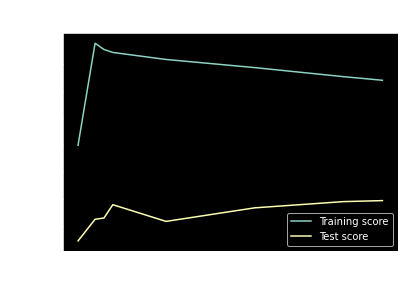

In [125]:
import numpy as np
from sklearn.model_selection import learning_curve

train_sizes = [2,50,75,100,250,500,750, 860]
# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb.XGBRegressor(n_estimators = 500, max_depth = 16), X=X, y=y, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

In [103]:
X.reset_index(drop=True, inplace=True)

In [109]:
y.reset_index(drop=True, inplace=True)

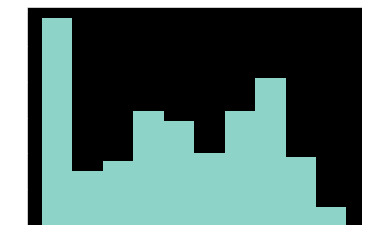

In [127]:
plt.hist(y_pred);

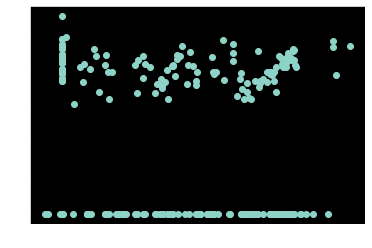

In [130]:
plt.scatter(y_pred, y_test);

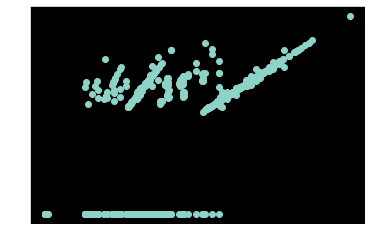

In [133]:
plt.scatter(y_pred_train, y_train);

In [136]:
y_pred[y_pred > 1.5]

array([2.1741438, 2.5383484, 1.923576 , 1.8492961, 1.5132921, 1.9174966,
       1.7092869, 1.6435106, 1.880379 , 1.7286545, 1.6037141, 1.8538833,
       1.9519873, 2.149008 , 2.069017 , 1.6854084, 1.51797  , 1.7699945,
       1.7286545, 2.6954057, 1.9983717, 2.1190634, 2.0045002, 1.6796235,
       1.9874909, 2.0318294, 2.1741438, 2.0590518, 1.7309198, 1.7542657,
       2.164307 , 1.7335155, 1.8043811, 2.1190634, 2.2888129, 1.6037141,
       1.5747157, 1.8571888, 2.5383484, 2.1623576, 1.7335155, 1.7088549,
       1.880379 , 2.2392964, 1.947685 , 1.6037141, 2.1619155, 2.0744355,
       2.1619155, 2.1347916, 1.8251803, 1.9519873, 1.947685 , 2.1030214,
       1.7585107, 2.0986052, 1.561229 , 2.0925248, 2.5680585, 2.149008 ,
       1.9519873, 2.0410912, 1.9503769, 1.9732916, 2.069017 , 1.7738979,
       2.0493426, 2.2290487, 2.4932861, 1.7776167, 2.0022957, 1.7092869,
       1.8567977, 1.9828682, 1.9519873, 1.7286545, 2.103026 , 1.8406295,
       1.8103997, 2.172702 , 2.1889544, 1.9828682, 

In [138]:
y_test.reset_index(drop=True, inplace=True)

In [139]:
y_pred = pd.Series(y_pred)

In [151]:
y_pred_filter = y_pred[y_pred > 1.9]
y_pred_filter_2 = y_pred[y_pred > 2.0]

In [152]:
y_test.loc[y_pred_filter.index].mean()

payout_under_2.5_pinacle    1.095932
dtype: float64

In [153]:
y_test.loc[y_pred_filter_2.index].mean()

payout_under_2.5_pinacle    1.12381
dtype: float64

In [147]:
y_test.loc[y_pred_filter_2.index].mean()

payout_under_2.5_pinacle    42
dtype: int64